In [1]:
import numpy as np
import gensim
import pandas as pd
import seaborn as sns
import ast
import re
import operator
import matplotlib.pyplot as plt
from neurotools.language.simple_tokenizer import SimpleTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

From the last notebook, we observed that **cool** and **uncool** (and same as **attractive** and **unattractive**) appear on the same side of the correlations.

Looking at the Polish tokenizer, I noticed that the tokenizer actually removes the '**nie**' prefix, which signifies a negation. This is what causes the issue in the previous paragraph, since this causes the dimensions to have almost the same vector representation (we will see this in Section 2). 

However, when I plugged words with 'nie' into the Polish embedding model, I noticed that it was not in the vocabulary. As a fix, we can remove from our dimensions and from the FB posts words that have '**nie**'.

# Volkswagen Social Media Success #4

## Plan
1. Do the same tasks as in Notebook 2, but ignore words that start with **nie**.
3. Get correlations between these defined features and the success metric.

## Notebook Contents
1. Load the tokenizer, embedding and data files
2. Define features based on token list
3. Correlations with dimensions
4. Conclusion

# Load the tokenizer, embedding and data files

In [2]:
emb = gensim.models.KeyedVectors.load_word2vec_format('data/pl_pl_commoncrawl_v3.bin', binary=True, encoding='utf-8', unicode_errors='ignore')

In [3]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


In [4]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys() and word != 'pistolet']
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [5]:
def fix_labels(x):
    if not pd.isnull(x['en_label']):
        label = x['en_label']
    else:
        label = x['de_label']#re.sub(r'[^a-z]', '', x['en'].split()[0].lower()) + '_nan'
    return label

In [6]:
def preprocess_dimensions():
    dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'de_label', 'pl', 'en']]
    dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
    dimensions['pl_no_nie'] = dimensions['pl'].map(lambda words: tokenizer.tokenize(' '.join([word for word in words.split() if not word.startswith('nie')])))
    dimensions['dimension'] = dimensions['pl_no_nie'].map(lambda x: get_average_vector(x, emb))
    dimensions['label'] = dimensions.apply(fix_labels, axis=1)
    return dimensions

In [7]:
dimensions = preprocess_dimensions()

In [8]:
simp = pd.read_csv('data/simplified_data_no_nie.csv')
simp['Post_text'] = simp['Text_no_nie'].map(ast.literal_eval)
# remove tokens starting with nie
simp['Post_text'] = simp['Post_text'].map(lambda words: [word for word in words if not word.startswith('nie')])

In [9]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

# get idf for each word

In [10]:
def get_idf_map(pl):
    tfidf = TfidfVectorizer(use_idf=True)
    pl['Post_text_string'] = pl['Post_text'].map(lambda x: ' '.join(x))
    tfidf.fit_transform(pl['Post_text_string'])
    word_to_idf = dict((x[0], tfidf.idf_[x[1]]) for x in sorted(tfidf.vocabulary_.items(), key=operator.itemgetter(1)))
    return word_to_idf

In [11]:
# note: most words have high idf (i.e. once lang lumabas)
#pd.Series(tfidf.idf_).hist(bins=100)

# define plotting functions

In [12]:
def get_label(string):
    """
        Convert feature names to 'more X association' labels
    """
#     return 'more {} associations'.format(string[5+string[4:].find('_'):])
    if string != 'success':
        return string[5+string[4:].find('_'):]
    else:
        return string

In [13]:
def get_top_bot(pl, label, top_string = ''):
    """
        Get the top 10 positive and negative correlations and plot these in bar charts.
        Also return a csv file of the pairwise correlations of the associations and 
        success metric.
    """
    corr_matrix = pl.corr()
    corr_success = corr_matrix['success']
    corr_success = corr_success[~pd.isnull(corr_success)].sort_values(ascending=False)
    upper = list(corr_success.iloc[1:11].index)
    lower = list(corr_success.iloc[-10:].index)
    dims_to_graph = upper + lower
    to_bar = corr_success.loc[dims_to_graph].sort_values(ascending=True)
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[:10], to_bar.values[:10], color='lightcoral')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[:10], [get_label(x) for x in np.array(to_bar.index)[:10]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/idf{}/bot_{}_10.png'.format(top_string, label), bbox_inches='tight');
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[10:], to_bar.values[10:], color='limegreen')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[10:], [get_label(x) for x in np.array(to_bar.index)[10:]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/idf{}/top_{}_10.png'.format(top_string, label), bbox_inches='tight');
    
    corr_matrix.to_csv('data/brands/idf{}/unlabeled_all_correlogram_{}.csv'.format(top_string, label))

    matrix_cols = ['success'] + dims_to_graph
    correlogram = corr_matrix.loc[matrix_cols, matrix_cols]
    correlogram.index = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.index]
    correlogram.columns = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.columns]
    correlogram.to_csv('data/brands/idf{}/correlogram_{}.csv'.format(top_string, label))
    
    plt.figure(figsize=(16,12))
    sns.heatmap(correlogram)
    plt.title(label, size = 20)
    plt.xticks(size=15, rotation = 90);
    plt.yticks(size=15, rotation = 0);
    plt.savefig('fig/brands/idf{}/correlogram_{}.png'.format(top_string, label), bbox_inches='tight');

# get sentence vector

In [14]:
def get_weighted_average_vector(words, word_to_idf, emb, top_x = None):
    """
        Average the word vectors of a list of words.
    """
    # only consider words IN embedding model and in TFIDF vectorizer
    words = [word for word in words if word in word_to_idf.keys() and word in emb.vocab.keys()]
    if top_x != None:
        ranked_words = [word for word in sorted(words, key=lambda x: -word_to_idf[x])]
        # sometimes words at the boundary are equal to words below boundary: include these words
        words = [word for word in ranked_words if word_to_idf[word] >= word_to_idf[ranked_words[round(top_x*len(words))-1]]] 
    weighted = [word_to_idf[word] * emb[word] for word in words]
    total = np.sum(weighted, axis=0)
    count = len(weighted)
    return total / count

In [15]:
def get_similarity_with_dimensions(row, dimensions):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        dimensions : dataframe containing Neuroflash dimensions
    """
    for k in range(dimensions['dimension'].shape[0]):
        name = 'dim_' + str(k) + '_' + str(dimensions['label'].iloc[k])
        # define a new column for the cosine similarity of dimension k and the post text
        row[name] = cosine_similarity(row['wv'], dimensions['dimension'].iloc[k])
    return row

In [16]:
def get_similarity_features(pl, emb, dimensions, label, top_x = None):
    if top_x != None:
        top_string = '30'
    else:
        top_string = ''
    word_to_idf = get_idf_map(pl)
    pl['wv'] = pl['Post_text'].map(lambda x: get_weighted_average_vector(x, word_to_idf, emb, top_x))
    pl = pl.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)
    pl = pl.convert_objects(convert_numeric=True)
    pl.to_csv('data/brands/idf{0}/no_nie_{0}tfidf_{1}.csv'.format(top_string, label), index=False)
    return pl

# MODE1 : Weighted Average

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


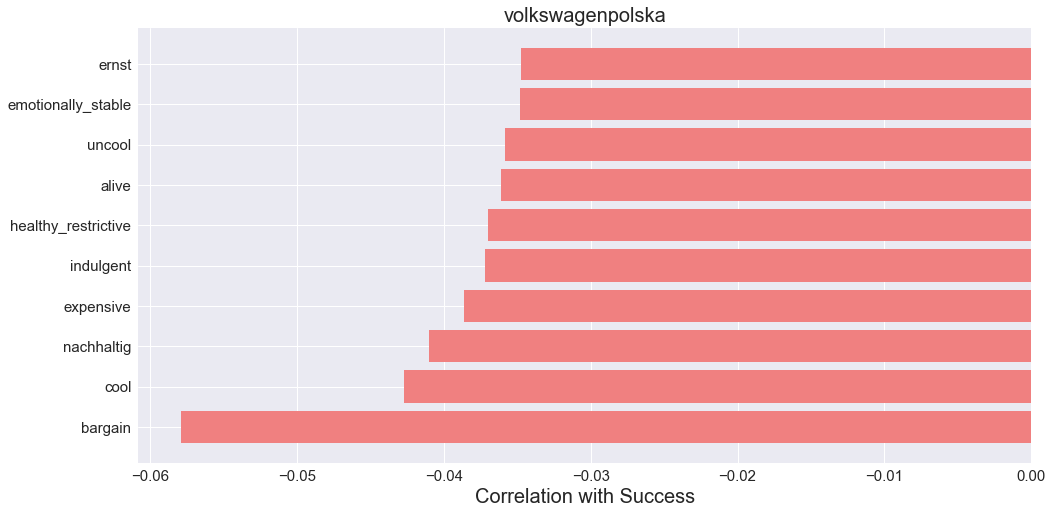

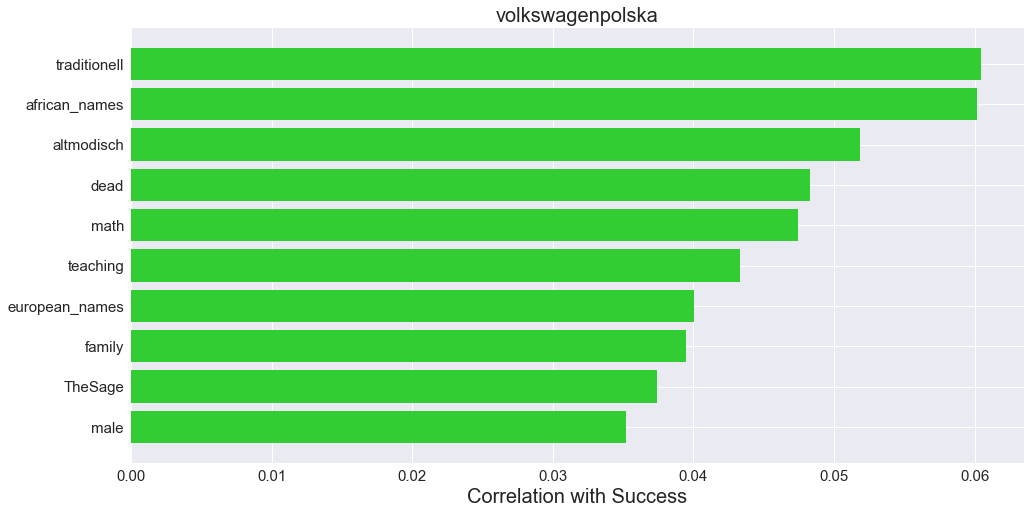

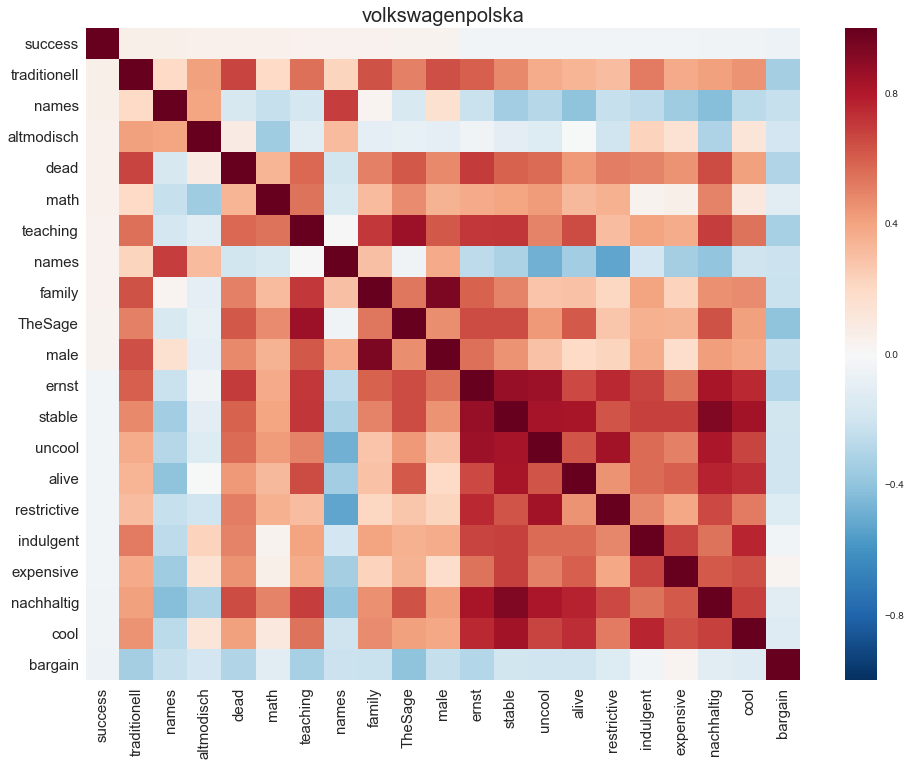

In [17]:
feats = get_similarity_features(simp, emb, dimensions, 'volkswagenpolska')
get_top_bot(feats, 'volkswagenpolska')

# MODE2: Average of Top 30%

## idf weighted average

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


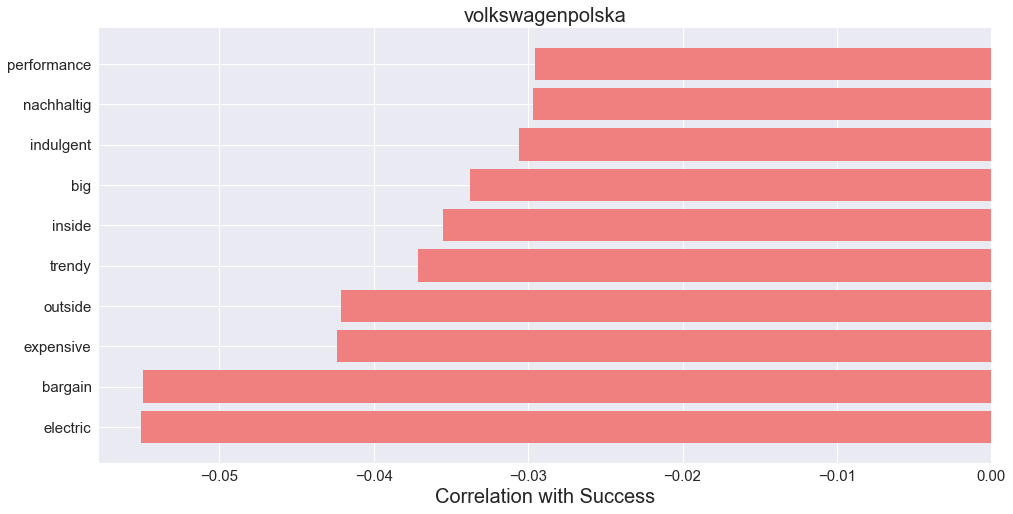

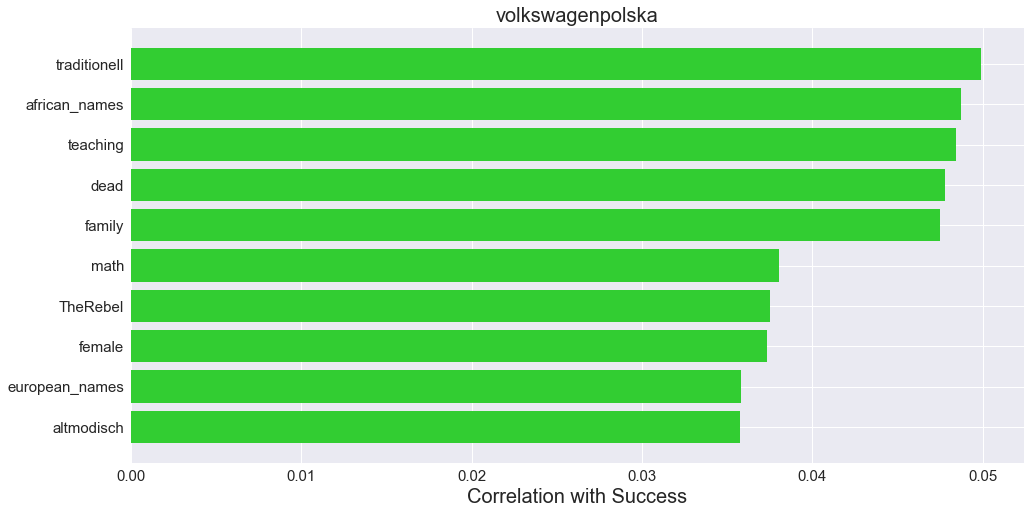

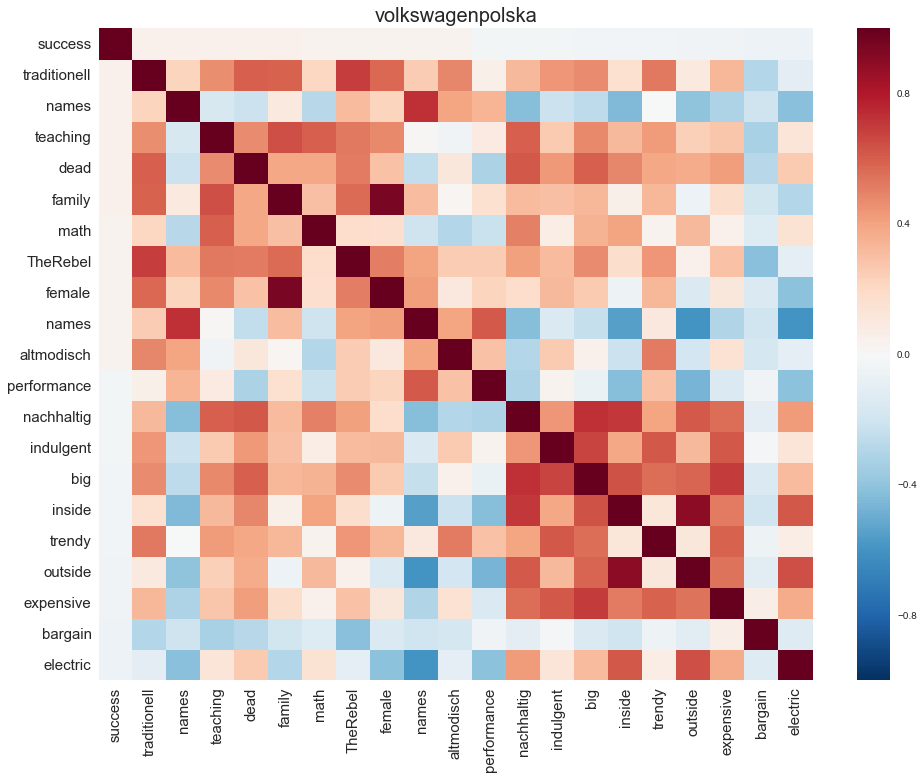

In [18]:
feats = get_similarity_features(simp, emb, dimensions, 'volkswagenpolska', 0.3)
get_top_bot(feats, 'volkswagenpolska', '30')

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


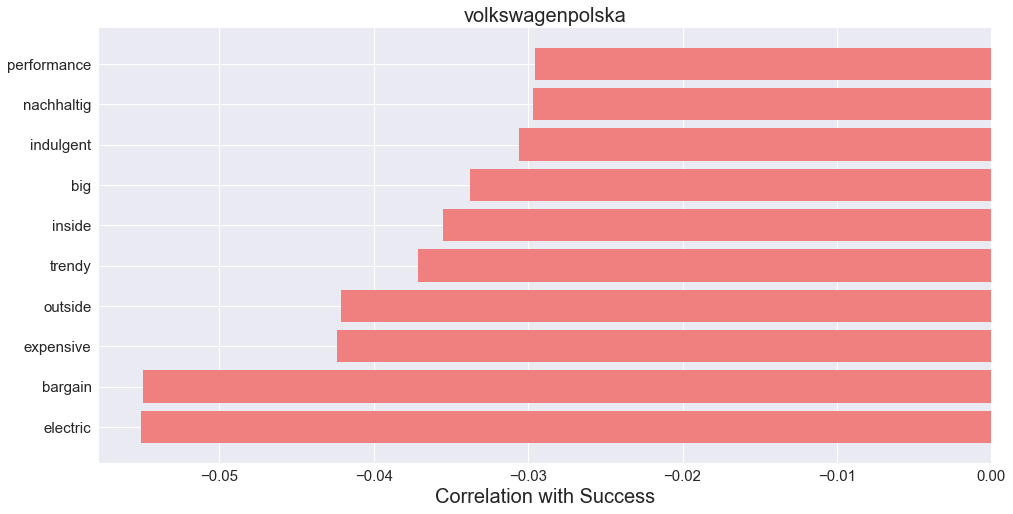

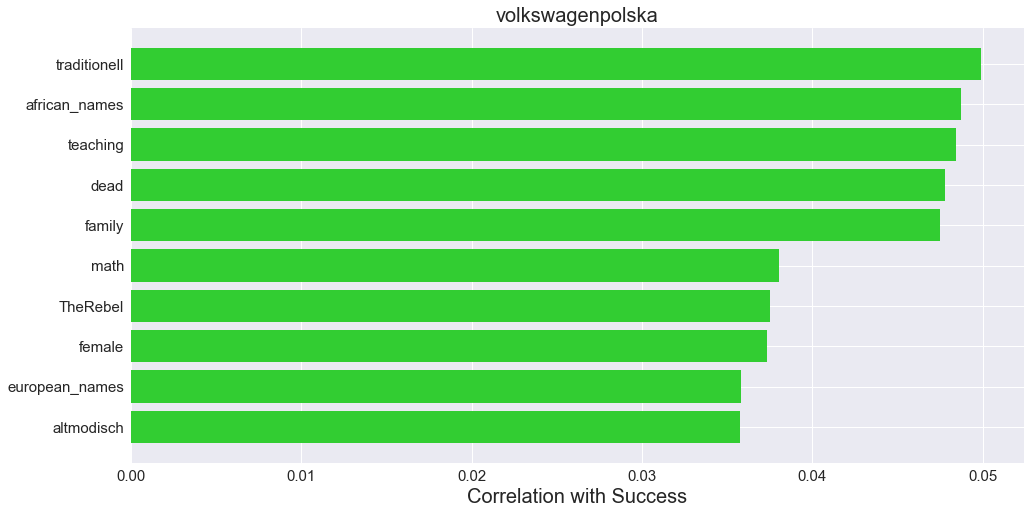

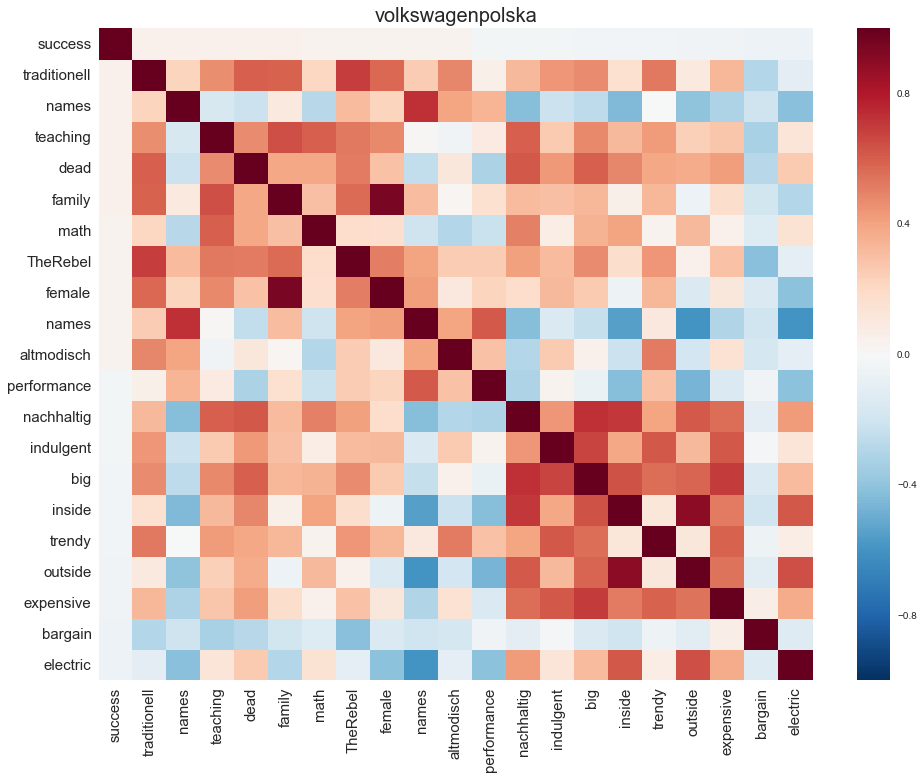